## Supplement 4: Classification

In [1]:
%matplotlib inline
import numpy as np


### 4.3 Programming Task: Song popularity prediction using Logistic regression
The datasets __train-songs.csv__ and __test-songs.csv__ contain audio properties of various tracks collected from the music streaming site Spotify.


The goal of the task is to train a logistic regression classifier that predicts if
a given track is popular or not.
The dataset consists of 9 columns.
The first 8 columns contain various audio properties
which are provided as input features to the model.
The last column contains the class labels given by 0(not popular) and 1(popular).

i\. Implement the loss function and its gradient for the logistic regression model.
 

In [2]:
def loss_function(input, target):
    #avoid numerical errors
    input_clamp = np.clip(input, np.finfo(float).eps, 1 - np.finfo(float).eps)
    return -np.sum(target * np.log(input_clamp) + (1 - target) * np.log(1 - input_clamp)) / len(target)


def sigmoid(input):
    return 1 / (1 + np.exp(-input))


def loss_function_gradient_weights(w, X, y):
    return np.dot(X.T, sigmoid(X.dot(w)) - y) / len(y)

   ii\. Using the gradient descent algorithm, train the logistic regression model.
You may reuse/modify the gradient descent algorithm from the previous supplement.




In [3]:
def gradient_descent(grad_func, num_features=2, random_seed=42, lr=30,
                     min_weight_dist=1e-6, max_iter=1e4, init_bounds=(-1, 1), **kwargs):
    np.random.seed(random_seed)
    weight_dist = np.inf
    w_init = np.random.uniform(*init_bounds, num_features)
    w = w_init.copy()
    loss_history = [loss_function(sigmoid(kwargs['X'].dot(w)), kwargs['y'])]
    iter_num = 0
    while weight_dist > min_weight_dist and iter_num < max_iter:
        w_new = w - lr * grad_func(w, **kwargs)
        weight_dist = np.linalg.norm(w - w_new)
        w = w_new
        iter_num += 1
        loss = loss_function(sigmoid(kwargs['X'].dot(w)), kwargs['y'])
        loss_history.append(loss)

    print(f'last iteration: {iter_num}, weight_dist: {weight_dist}')

    return w, loss_history

In [4]:
import pandas as pd
df = pd.read_csv('train-songs.csv')
df.head()

,danceability,key,loudness,acousticness,instrumentalness,liveness,valence,tempo,popular
0,0.391,8,-9.532,0.478,0.000006,0.1160,0.138,105.593,0.0
1,0.628,1,-13.834,0.156,0.010400,0.0836,0.761,102.974,0.0
2,0.613,3,-22.789,0.864,0.000000,0.2690,0.371,75.104,0.0
3,0.504,2,-5.931,0.414,0.000000,0.0845,0.163,135.927,1.0
4,0.698,9,-3.840,0.101,0.000000,0.1070,0.931,124.042,1.0


In [5]:
target = 'popular'
df.insert(0, 'bias', 1)
X = df.drop(columns=target).values
y = df[target].values

In [6]:
w, _ = gradient_descent(loss_function_gradient_weights, num_features=X.shape[1], lr=9e-4, max_iter=1000, X=X, y=y)

last iteration: 1000, weight_dist: 0.011945854264717306


iii\. Using model predictions on __test-songs.csv__, build the confusion
matrix and subsequently calculate the precision, recall, and F1-score for a threshold of 0.4.


In [7]:
import matplotlib.pyplot as plt


def plot_confusion_matrix(confusion_matrix, title='Confusion matrix', cmap=plt.cm.gray_r):
    fig, ax = plt.subplots(figsize=(13, 7))
    ax.matshow(confusion_matrix, cmap='Blues')

    for (i, j), z in np.ndenumerate(confusion_matrix):
        ax.text(j, i, z, ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', edgecolor='0.3'))
    plt.title(title)
    tick_marks = np.arange(len(confusion_matrix))
    plt.xticks(tick_marks, np.arange(len(tick_marks)))
    plt.yticks(tick_marks, np.arange(len(tick_marks)))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

precision: 0.67
recall: 0.94
F1-score: 0.78


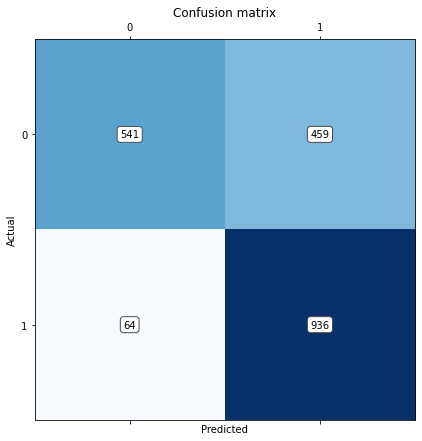

In [8]:
threshold = 0.4
df_test = pd.read_csv('test-songs.csv')
df_test.insert(0, 'bias', 1)
X_test = df_test.drop(columns=target).values
y_test = df_test[target].values
predicts = (sigmoid(X_test.dot(w)) > threshold).astype(int)
confusion_matrix = np.array([
    [((predicts == 0) & (predicts == y_test)).sum(), ((predicts == 1) & (predicts != y_test)).sum()],
    [((predicts == 0) & (predicts != y_test)).sum(), ((predicts == 1) & (predicts == y_test)).sum()],
])

plot_confusion_matrix(confusion_matrix)
precision = confusion_matrix[1, 1] / confusion_matrix[:, 1].sum()
recall = confusion_matrix[1, 1] / confusion_matrix[1, :].sum()
print(f'precision: {round(precision, 2)}')
print(f'recall: {round(recall, 2)}')
print(f'F1-score: {round(2 * precision * recall / (precision + recall), 2)}')

iv\. Plot the ROC curve for the model and calculate the AUC metric of your model.


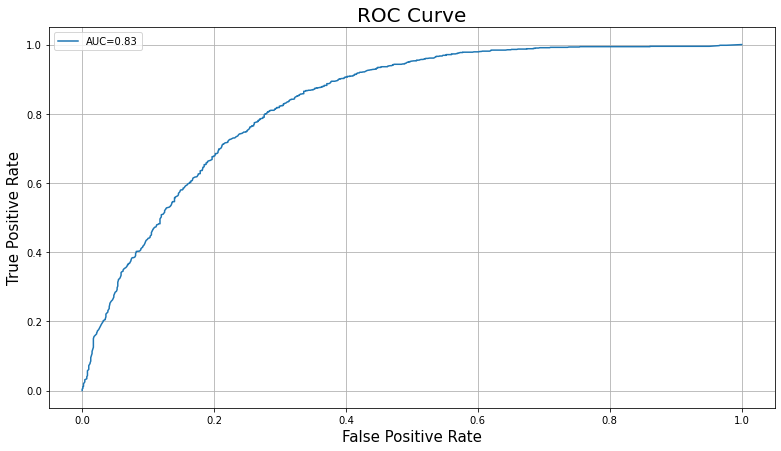

In [9]:
def get_roc(predicts, y_true):
    thresholds = np.linspace(0, 1, 1000)
    fpr = []
    tpr = []

    positives = sum(y_true)
    negatives = len(y_true) - positives

    for thresh in thresholds:
        FP = 0
        TP = 0
        for predicted, actual in zip(predicts, y_true):
            if predicted > thresh:
                if actual == 1:
                    TP += 1
                else:
                    FP += 1
        fpr.append(FP / negatives)
        tpr.append(TP / positives)
    return fpr, tpr


def get_auc(tpr, fpr):
    zero = np.array([0])
    tpr_diff = np.abs(np.r_[(np.diff(tpr), zero)])
    fpr_diff = np.abs(np.r_[(np.diff(fpr), zero)])
    auc = np.dot(tpr, fpr_diff) + np.dot(tpr_diff, fpr_diff) / 2
    return auc

fpr, tpr = get_roc(sigmoid(X_test.dot(w)), y_test)
plt.figure(figsize=(13, 7))
plt.plot(fpr, tpr, label=f'AUC={round(get_auc(tpr, fpr), 2)}')
plt.title('ROC Curve', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=15)
plt.xlabel('False Positive Rate', fontsize=15)
plt.legend()
plt.grid(True)

v\. Consider the simpler models given below.The input $\mathbf{x}$ in these models takes only 4 input features from the given dataset.

- Model A $~~~~~~~~~~~$   $\mathbf{x}$ = $[$ danceability, key, valence, tempo $]^\top$
- Model B $~~~~~~~~~~~$  $\mathbf{x}$ = $[$ danceability, loudness, acousticness, instrumentalness $]^\top$
- Model C $~~~~~~~~~~~$ $\mathbf{x}$ = $[$ key, liveness, valence, tempo $]^\top$

Train these models using your logistic regression implementation and determine the best performing model using the AUC metric.

In [10]:
set_features = (
    ('Model A', ['danceability', 'key', 'valence', 'tempo']),
    ('Model B', ['danceability', 'loudness', 'acousticness', 'instrumentalness']),
    ('Model C', ['key', 'liveness', 'valence', 'tempo']),
)

for model, features in set_features:
    columns = ['bias'] + features
    X = df[columns].values
    y = df[target].values
    X_test = df_test[columns].values
    y_test = df_test[target].values
    w, _ = gradient_descent(loss_function_gradient_weights, num_features=X.shape[1], lr=9e-4, max_iter=1000, X=X, y=y)
    pred_score = sigmoid(X_test.dot(w))
    fpr, tpr = get_roc(pred_score, y_test)
    print(f'{model}: AUC={round(get_auc(tpr, fpr), 2)}')

last iteration: 1000, weight_dist: 0.04553669374105875
Model A: AUC=0.47
last iteration: 1000, weight_dist: 0.00010479293769719155
Model B: AUC=0.83
last iteration: 1000, weight_dist: 0.04474029680873023
Model C: AUC=0.46


**Despite the fact that learning rate should be tuned for each model separately, Model B seems to be the best**